# day 3 tutorial

**users will need to install ipywidgets and ipyleaflet to use the widgets outside of MyBinder environment. Then they need to enable the widget extension for jupyter:**
```
pip install ipywidgets
pip install ipyleaflet
jupyter nbextension enable --py widgetsnbextension
```
**maybe we don't display the hovers. it's kinda hack-y implementation. ipyleaflet map widget doesn't have great options for this type of interaction. this is the purged hover handler ocde:**
```
def hover_handler(event=None, id=None, properties=None):
    if len(m.layers)==3:
        m.remove_layer(m.layers[-1])

    nyears = len([key for key in properties.keys() if "MEAN" in key])
    data = {'year': [], 'mean': [], 'std': []}
    for i in range(1,nyears):
        data['year'].append(1980+i)
        data['mean'].append(properties["MEAN_"+str(i)])
        data['std'].append(properties["STD_"+str(i)])
    df = pd.DataFrame(data)
        
    popup = mwg.Popup(location=properties['centroid'], 
                      child=wg.HTML("{put some info here}"), 
                      auto_close=True,
                      class_name="custom")
    m.add_layer(popup)
    
layer.on_hover(hover_handler)
m.add_layer(layer)
m
```
**purged imports:**
```
import math
import matplotlib as mpl
import matplotlib.pyplot as plt, mpld3
mpl.rcParams['figure.figsize'] = [8, 7]
```

In [1]:
import os
import json
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

import requests
import numpy as np
import pandas as pd
import xarray as xr
from io import StringIO

# widgets/map colors
import ipywidgets as wg
import ipyleaflet as mwg
import math
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# miscellaneous settings
smap_res = 9
basemap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)

## soil moisture visualizer datasets

In [2]:
smvds = pd.read_csv("docs/smvdatasets.csv", index_col="Column fieldname", header=0)
smvds

,Description,Units
Column fieldname,,
SoilSCAPE_surface,Mean volumetric (%) soil moisture at 0-5 cm so...,m3/m3
SoilSCAPE_rootzone,Mean volumetric (%) soil moisture at 0-100 cm ...,m3/m3
AirMOSS_in-ground_surface,Mean volumetric (%) soil moisture at 0-5 cm so...,m3/m3
AirMOSS_in-ground_rootzone,Mean volumetric (%) soil moisture at 0-100 cm ...,m3/m3
COSMOS_surface,Mean volumetric (%) soil moisture at 0-5 cm so...,m3/m3
COSMOS_rootzone,Mean volumetric (%) soil moisture at 0-100 cm ...,m3/m3
AirMOSS_L2_3_surface,Mean volumetric (%) soil moisture at 0 cm soil...,m3/m3
AirMOSS_L2_3_rootzone,Mean volumetric (%) soil moisture at 0-30cm so...,m3/m3
AirMOSS_L4_rootzone,Mean volumetric (%) soil moisture at 0-100cm s...,m3/m3


## converting soil moisture visualizer output to xr.Dataset

In [3]:
f = "docs/daily-smap-ORNL-DAAC-PccIuo.txt"          # example smv output
df = pd.read_csv(f, header=4, index_col="time")
df.index = pd.to_datetime(df.index)

datasets = list(df)
df.head(5)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl,FLUXNET_surface,FLUXNET_rootzone
time,,,,,,,,,,,,,,,,,,,,,
2012-09-20,;;,;;,;nan;,;7.2;,4.86;7.16;9.2,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-21,;;,;;,;;,;;,9.55;9.6;9.67,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-22,;;,;;,;;,;;,9.34;9.49;9.57,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-23,;;,;;,;;,;;,9.14;9.38;9.52,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-24,;;,;;,;;,;;,8.95;9.27;9.49,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;19.59;,;36.24;,;;,;;


In [4]:
def getxr(series):

    # split columns into more columns; give names
    t = series.str.split(";", n = 2, expand=True)
    t.columns = ["Min", "Mean", "Max"]

    # replace empty strings w numpy.nan; all dtypes to float
    for col in t.columns:
        t[col].loc[t[col]==''] = np.nan
        t[col] = t[col].astype(float)
        
    # make an xarray.Dataset
    x = xr.Dataset(t)
    x.attrs = smvds.loc[series.name].to_dict()
    x.attrs["_FillValue"] = -9999.
    
    return(x)

# make dictionary of xr.Datasets; print one
AirMOSS_L4_rootzone = getxr(df['AirMOSS_L4_rootzone'])
AirMOSS_L4_rootzone

/home/jack/.local/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<xarray.Dataset>
Dimensions:  (time: 2354)
Coordinates:
  * time     (time) datetime64[ns] 2012-09-20 2012-09-21 ... 2019-03-01
Data variables:
    Min      (time) float64 4.86 9.55 9.34 9.14 8.95 ... nan nan nan nan nan
    Mean     (time) float64 7.16 9.6 9.49 9.38 9.27 9.18 ... nan nan nan nan nan
    Max      (time) float64 9.2 9.67 9.57 9.52 9.49 9.46 ... nan nan nan nan nan
Attributes:
    Description:  Mean volumetric (%) soil moisture at 0-100cm soil depth
    Units:        m3/m3
    _FillValue:   -9999.0

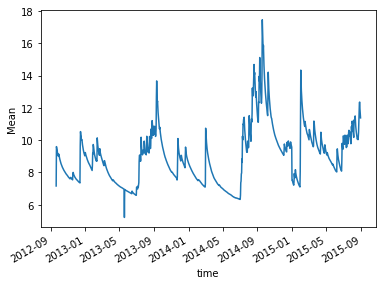

In [5]:
%matplotlib inline
AirMOSS_L4_rootzone['Mean'].plot()

## requests

In [6]:
r = requests.get(
    "https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=32.8129&ln=-109.4379&d=smap",
    cookies=dict(ORNL_DAAC_USER_NUM="1"))

r.text

"Filename: daily-smap-ORNL-DAAC-XXXXXX\nData_Set_Name: Daily soil moisture and ancillary datasets. Data columns are delineated by commas. The values in each column when separated by semicolons represent the daily range as 'min; mean; max'.\nLocation: 32.8129, -109.4379\nCitation: ORNL DAAC. 2017. Soil Moisture Visualizer. ORNL DAAC, Oak Ridge, Tennessee, USA. http://dx.doi.org/10.3334/ORNLDAAC/1366\n\n\ntime,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,tmax,tmin,ET,LST_Day,LST_Night,EVI,AirMOSS_in-ground_surface,AirMOSS_in-ground_rootzone,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl\r\n2002-04-01,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;13.59;,;24.89;\r\n2002-04-02,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,

In [7]:
lat, lon = StringIO(r.text).readlines()[2].split("Location: ")[1].strip().split(", ")
df = pd.read_csv(StringIO(r.text), header=4, index_col="time")
df.head(10)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl
time,,,,,,,,,,,,,,,,,,,,,
2002-04-01,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;13.59;,;24.89;
2002-04-02,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-03,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-04,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-05,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-06,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-07,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-08,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;20.77;,;27.37;
2002-04-09,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;


## open shapefile with geopandas and organize; get some basic spatial metadata

In [8]:
# read shapefile to geodataframe
gdf = gpd.GeoDataFrame.from_file("sites/Sites_lf.shp")  

# get geodataframe as wgs84l get centroid of each polygon
gdf = gdf.to_crs({'init': 'epsg:4326'})
gdf['centroid'] = [(p.y, p.x) for p in gdf.centroid]

# make list of colors using matplotlib's colormapper
gdf['style'] = [{
    'color': colors.rgb2hex(d[0:3]), 
    'fillColor': colors.rgb2hex(d[0:3]), 
    'weight': 1, 'fillOpacity': 0.5
} for d in cm.Set3(np.linspace(0.0,1.0,len(gdf)))]

# get geometries from geodataframe as python dictionary; get bounds
geodict = json.loads(gdf.to_json())
bnds, series = gdf.bounds, gdf['geometry']

# get extent and centroid for whole file
minx, maxx = min(bnds['minx']), max(bnds['maxx'])
miny, maxy = min(bnds['miny']), max(bnds['maxy'])
centroid = ((maxy+miny)/2, (maxx+minx)/2)

# display first two rows of geodataframe
gdf.head(2)

,OBJECTID,RANGERDIST,REGION,FORESTNUMB,DISTRICTNU,DISTRICTOR,FORESTNAME,DISTRICTNA,GIS_ACRES,SHAPE_Leng,...,STD_29,STD_30,STD_31,STD_32,STD_33,STD_34,STD_35,geometry,centroid,style
0,61,99030501010343,03,05,01,030501,Coronado National Forest,Douglas Ranger District,434025.200,3.963602,...,446.146563,453.982071,557.405375,339.841942,599.562885,470.501168,343.082608,(POLYGON ((-109.2462605499999 32.0543309500000...,"(31.774734099094083, -109.3275890439515)","{'fillOpacity': 0.5, 'weight': 1, 'color': '#8..."
1,62,99030503010343,03,05,03,030503,Coronado National Forest,Sierra Vista Ranger District,321534.997,2.854066,...,502.615547,430.908201,701.371540,272.786808,445.029396,525.713796,242.986111,(POLYGON ((-110.6378639499999 31.6445072200000...,"(31.505073066518996, -110.53696719971326)","{'fillOpacity': 0.5, 'weight': 1, 'color': '#f..."


In [9]:
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?lt={lat}&ln={lon}&d={d}"


def smvrequest(id,lat,lon,d="smap"):
    
    r = requests.get(
        url.format(
            lat=lat, 
            lon=lon, 
            d=d), cookies=dict(ORNL_DAAC_USER_NUM="1"))
    txt = StringIO(r.text)   
    lat, lon = txt.readlines()[2].split("Location: ")[1].strip().split(", ")
    df = pd.read_csv(txt, header=4, index_col="time")
    
    return(lat, lon, df)

# EASE Grid

two binary files with (almost) global lat, lon coordinates:

In [10]:
lats = "docs/EASE2_M09km.lats.3856x1624x1.double"
lons = "docs/EASE2_M09km.lons.3856x1624x1.double"

# read the files to two numpy arrays
lat_array = np.fromfile(lats, dtype=np.float64).flatten()
lon_array = np.fromfile(lons, dtype=np.float64).flatten()

# zip the arrays with np.dstack
c = np.dstack((lon_array, lat_array))[0]
print("Array shape: "+str(c.shape))
c

Array shape: (6262144, 2)


array([[-179.9533195 ,   84.6564188 ],
       [-179.85995851,   84.6564188 ],
       [-179.76659751,   84.6564188 ],
       ...,
       [ 179.76659751,  -84.6564188 ],
       [ 179.85995851,  -84.6564188 ],
       [ 179.9533195 ,  -84.6564188 ]])

### Most straightforward way to select coordinates inside a polygon is to first index the coordinate array using the polygon extent:

In [11]:
selection = c[(-90<lon_array) & (lon_array<-85) & (25<lat_array) & (lat_array<30)]
selection

array([[-89.9533195 ,  29.94568162],
       [-89.85995851,  29.94568162],
       [-89.76659751,  29.94568162],
       ...,
       [-85.19190871,  25.02339698],
       [-85.09854772,  25.02339698],
       [-85.00518672,  25.02339698]])

### Simple function uses the logic above to select an array of coordinates within bounding extent of the polygon:

In [12]:
def get_ease(geom):
    
    # geom.bounds method returns a tuple of bounding coordinates:
    sel_minlon, sel_minlat, sel_maxlon, sel_maxlat = geom.bounds
    
    # index the xy array with bool conditions based on extent
    sel_ease = c[(sel_minlon<lon_array) & (lon_array<sel_maxlon) & 
                 (sel_minlat<lat_array) & (lat_array<sel_maxlat)]
    
    # further reduce to pts contained within the selected geometry
    sel_ease_poly = [
        pt for pt in sel_ease if geom.contains(Point(pt[0], pt[1]))]
    
    return(sel_ease_poly)

### Test with polygon feature number 8, printing the first five coordinates:

In [13]:
get_ease(gdf.iloc[8].geometry)[:5]

[array([-107.22510373,   37.91860119]),
 array([-107.13174274,   37.91860119]),
 array([-107.03838174,   37.91860119]),
 array([-106.94502075,   37.91860119]),
 array([-106.85165975,   37.91860119])]

## initialize the map and add the site polygons

In [14]:
# initialize widgets
m = mwg.Map(layers=(basemap,), center=(33, -109), zoom=6, scroll_wheel_zoom=True) 
layer = mwg.GeoJSON(
    data=geodict, hover_style={'color': "white", 'weight': 2, 'fillOpacity': 0.5})

m.add_layer(layer)

## add click handler; display map
click handler calls `get_ease` upon polygon click, reduces array of ease grid centroids using polygon extent, uses shapely `contains()` to determine if point is inside polygon (geopandas is basically pandas with shapely geometry column), makes feature and adds to layer group.

In [17]:
samples = {}

def click_handler(**kwargs):
    
    # click callback returns two separate objects; differentiate
    if "id" not in kwargs.keys():
        return(None)
    
    # get geopandas row corresponding to clicked polygon; get the geometry
    g = gdf.iloc[int(kwargs['id'])]
    geom = g.geometry
    
    # use our function to select an array of coords within geom extent
    ease_grid = get_ease(geom)
    
    # iterate over array of coordinates and make point layers
    point_features = []
    
    for i, pt in enumerate(ease_grid):
        point_features.append(mwg.CircleMarker(location=(pt[1], pt[0])))
        lat, lon, df = smvrequest(i, pt[0], pt[1])
        samples[i] = {"lon": lon, "lat": lat, "data": {d: getxr(df[d]) for d in list(df)}}
 
            
    # make a layer group from the list of point features
    point_group = mwg.LayerGroup(layers=tuple(point_features))
  
    # get the centroid of selected layer; center and zoom the map
    centroid = geom.centroid
    m.center = (centroid.y, centroid.x)
    m.zoom = 9
    
    # finally, add all of the layers
    m.add_layer(point_group)


layer.on_click(click_handler)
m

Map(basemap={'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a…

EmptyDataError: No columns to parse from file

EmptyDataError: No columns to parse from file

In [16]:
fig, axes = plt.subplots(ncols=2)

air1d.plot(ax=axes[0])
air1d.plot.hist(ax=axes[1])

plt.tight_layout()

plt.draw()

(TileLayer(attribution='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', max_zoom=20, min_zoom=1, name='Esri.WorldImagery', options=['max_zoom', 'tile_size', 'attribution', 'detect_retina', 'min_zoom'], url='http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'),
 GeoJSON(data={'features': [{'properties': {'Rowid_': 59, 'RANGE': 113, 'RANGERDIST': '99030501010343', 'Count_2': 8269.0, 'Count_30': 8234.0, 'Count_31': 8268.0, 'Count_23': 8252.0, 'MEAN_16': 1504.55295118, 'SHAPE_Leng': 3.96360236158, 'Count_3': 8270.0, 'Count_22': 8271.0, 'Count_13': 8263.0, 'MEAN_19': 1287.29642207, 'Count_17': 8263.0, 'STD_9': 712.378481005, 'Count_6': 8257.0, 'Count_34': 8219.0, 'DISTRICTNU': '01', 'SUM': -347986.0, 'STD_5': 772.114470606, 'MEAN_5': 1322.95211029, 'STD_32': 339.841942186, 'STD_23': 683.237357779, 'VARIETY': 96, 'STD': 15.107567792, 'STD_6': 813.987628712